## Bluebike Forecasting

Time series forecasting can broadly be categorized into the following categories:
- Classical / Statistical Models — Auto Regression, Moving Averages, Exponential smoothing, ARIMA, SARIMA, TBATS
- Machine Learning — XGBoost, Random Forest, or any ML model with reduction methods
- Deep Learning — RNN, LSTM<br>
Here we will explore **Auto Regression**

## What is linear regression forecasting?
Linear Regression Forecast (LRF) Linear regression is a statistical tool used to help predict future values from past values. A linear regression trendline uses the least squares method to plot a straight line through prices so as to minimize the distances between the prices and the resulting trendline.

Auto regression models such as AR,MA, ES, ARIMA, SARIMA all fall in the Linear regression category

A simple Linear regression model is as follows:<br>
$yhat = b0 + b1*X1$

While an autoregression model is as follows:<br>
$X(t+1) = b0 + b1*X(t-1) + b2*X(t-2)$

where the next value is predicted based on previous two values.


Autoregression is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step.


### Autocorrelation
An autoregression model makes an assumption that the observations at previous time steps are useful to predict the value at the next time step.

This relationship between variables is called correlation.

Reference: https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/






In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle

In [3]:
# Loading the data (All trip data)
trip_data = pd.read_pickle("/content/drive/MyDrive/blue_bikes_sales_prediction/data/raw_data.pkl")

In [4]:
trip_data.head(1)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code
0,350,2017-01-01 00:06:58,2017-01-01 00:12:49,67,MIT at Mass Ave / Amherst St,42.3581,-71.093198,139,Dana Park,42.36178,-71.1081,644,Subscriber,NaN


In [5]:
# preprocessing
def get_groupby(data,condition):
  '''
  Etract day, month, hour from timestamp
  grouping by condition = 'hour' or 'date','year'

  '''
  df = data.copy()
  
  # extracting the yesr,date,hour from time stamp
  df['year'] = df.starttime.dt.year
  df['month'] = df.starttime.dt.month
  df['date'] = df.starttime.dt.date
  df['hour'] = df.starttime.dt.hour

  if condition == 'year':
    df = df.groupby(['year']).size().reset_index(name = 'Totalrides')
  if condition == 'month':
    df = df.groupby(['year','month']).size().reset_index(name = 'Totalrides')
  if condition == 'date':
    df = df.groupby(['year','month','date']).size().reset_index(name = 'Totalrides')
  if condition == 'hour':
    df = df.groupby(['year','month','date','hour']).size().reset_index(name = 'Totalrides')    
  return df

In [6]:
df = get_groupby(trip_data,'date')
df.head(3)

,year,month,date,Totalrides
0,2017,1,2017-01-01,481
1,2017,1,2017-01-02,802
2,2017,1,2017-01-03,651


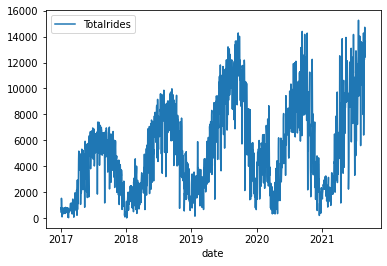

In [7]:
df = df[['date','Totalrides']]

df.plot(x = 'date')
plt.show()


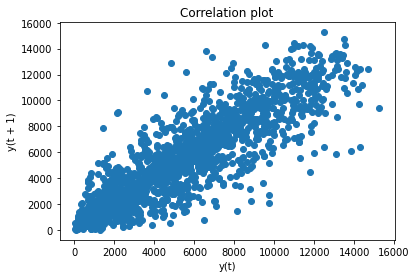

In [8]:
# checking the auto correlation
from pandas.plotting import lag_plot
lag_plot(df.Totalrides)
plt.title("Correlation plot")
plt.show()

we see that data is highly corelated

In [9]:
# checking the correlation with statistical method
values = df.Totalrides
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.869654
t+1  0.869654  1.000000


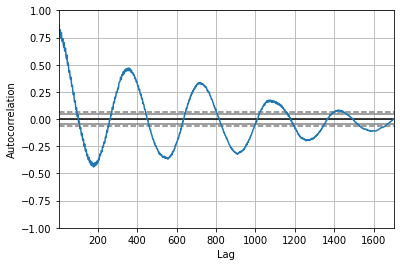

In [10]:
# auto correlation plots
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df.Totalrides)
plt.show()

Running the example shows the swing in positive and negative correlation as the total rides change across summer and winter seasons each previous year.<br>
The plot also includes solid and dashed lines that indicate the 95% and 99% confidence interval for the correlation values.

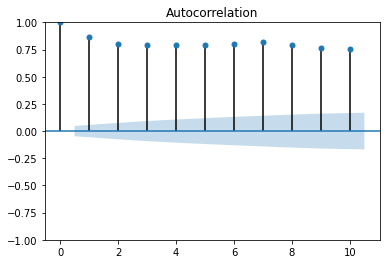

In [11]:
# the acf plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df.Totalrides, lags=10)
plt.show()

(1336,) (1336,) (365,) (365,)
Test MSE: 4783593.948


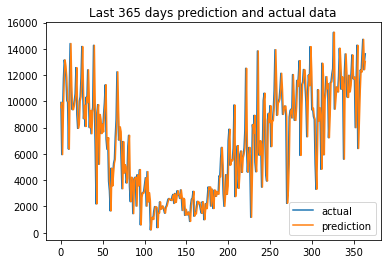

In [12]:
# base line model
from sklearn.metrics import mean_squared_error
series = df.Totalrides
# create lagged dataset
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-365], X[len(X)-365:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
print(train_X.shape,train_y.shape,test_X.shape,test_y.shape)
# persistence model
def model_persistence(x):
	return x
 
# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
plt.plot(test_y,label = "actual")
plt.plot(predictions,label = "prediction")
plt.legend()
plt.title("Last 365 days prediction and actual data")
plt.show()

In [13]:
!pip install statsmodels --upgrade

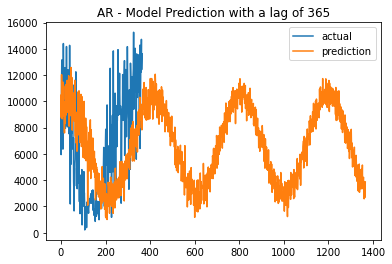

In [14]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
series = df.Totalrides
# split dataset
X = series.values
train, test = X[1:len(X)-365], X[len(X)-365:]
# train autoregression
model = AutoReg(train, lags=365)
model_fit = model.fit()
#print('Coefficients: %s' % model_fit.params)
# make predictions
#predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)+1000, dynamic=False)
# for i in range(len(predictions)):
# 	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
# rmse = sqrt(mean_squared_error(test, predictions))
# print('Test RMSE: %.3f' % rmse)
# plot results
plt.plot(test,label = "actual")
plt.plot(predictions,label = "prediction")
plt.legend()
plt.title("AR - Model Prediction with a lag of 365")
plt.show()

In [21]:
from sklearn.metrics import r2_score, mean_absolute_error
y_pred = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
print("r-squared error : ",r2_score(test, y_pred))
print("MAE error : ",mean_absolute_error(test, y_pred))

r-squared error :  -0.1791582249696606
MAE error :  3525.17179602089
